<a href="https://colab.research.google.com/github/abhranil-datascience/Day2-Resnet50_FromScratch/blob/master/ResnetFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################## Mount Drive ######################################## 
from google.colab import drive
drive.mount('/content/gdrive')

############################## Change Directory ###################################
import os
os.chdir('/content/gdrive/My Drive/ImageAnalytics/Day1-CNN/Dataset')

########## Suppress Warnings ############
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#################### Define Constant Folder Names and Get File Paths ###########################
DatasetDirectory='/content/gdrive/My Drive/ImageAnalytics/Day1-CNN/Dataset'
TrainingSet="training_set"
TestSet="test_set"
TrainingSetDirectory=DatasetDirectory+"/"+TrainingSet
TestSetDirectory=DatasetDirectory+"/"+TestSet
cat_directory="cats"
dog_directory="dogs"
TrainingSetCatDirectory=TrainingSetDirectory+"/"+cat_directory
TrainingSetDogDirectory=TrainingSetDirectory+"/"+dog_directory
FilePathsCatTrainingSet=[TrainingSetCatDirectory+"/"+fname for fname in os.listdir(TrainingSetCatDirectory) if '.jpg' in fname]
FilePathsDogTrainingSet=[TrainingSetDogDirectory+"/"+fname for fname in os.listdir(TrainingSetDogDirectory) if '.jpg' in fname]
TrainingSetFilePaths=FilePathsCatTrainingSet+FilePathsDogTrainingSet
import random
random.shuffle(TrainingSetFilePaths)
print("Number Of Training Set Cats: "+str(len(FilePathsCatTrainingSet))+ " || "+ 
      "Number Of Training Set Dogs: "+str(len(FilePathsDogTrainingSet))+ " || "+ 
      "Number of Training Set Images: "+str(len(TrainingSetFilePaths)))

Number Of Training Set Cats: 3928 || Number Of Training Set Dogs: 4000 || Number of Training Set Images: 7928


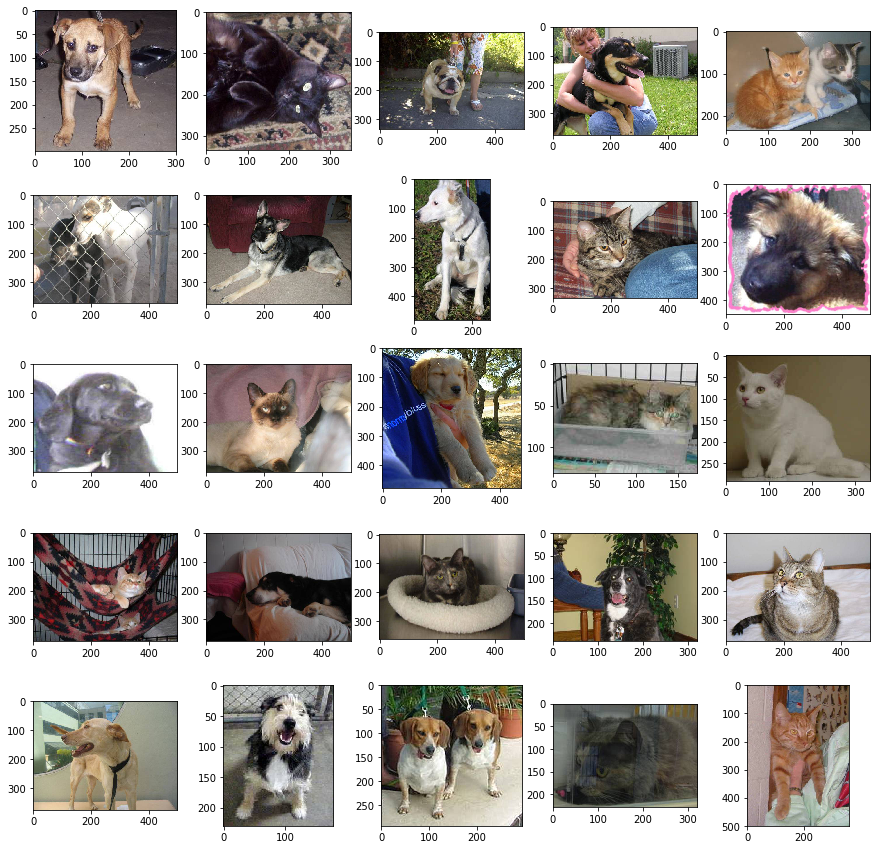

In [3]:
##################################### Visualize Data Set ##################################################
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig=plt.figure(figsize=(15,15))
columns = 5
rows = 5
for count in range(0,25):
  img=mpimg.imread(TrainingSetFilePaths[count])
  fig.add_subplot(rows, columns, count+1)
  imgplot = plt.imshow(img)
plt.show()

In [4]:
#################### Create Image Generator and Preprocess ################################################
from keras.preprocessing.image import ImageDataGenerator
train_image_generator=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,vertical_flip=True)
test_image_generator=ImageDataGenerator(rescale=1./255)
training_set=train_image_generator.flow_from_directory(directory=TrainingSet,target_size=(180,180),classes=['cats','dogs'],class_mode='binary',batch_size=90, shuffle=True)
#training_set.class_indices ==> {'cats': 0, 'dogs': 1}
test_set=test_image_generator.flow_from_directory(directory=TestSetDirectory,target_size=(180,180),classes=['cats','dogs'],class_mode='binary',batch_size=90, shuffle=True)
#test_set.class_indices ==> {'cats': 0, 'dogs': 1}

Using TensorFlow backend.


Found 7928 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
#################################################### Create Callbacks ###########################################################
BestModel="/content/gdrive/My Drive/ImageAnalytics/Day2-ResnetFromScratch/BestModel/best_model.hdf5"
from keras.callbacks import ModelCheckpoint,EarlyStopping
save_best_model=ModelCheckpoint(filepath=BestModel,monitor='val_acc',save_best_only=True,mode='max',verbose=2)
early_stopping=EarlyStopping(monitor='val_acc',min_delta=0.003,patience=25,mode='max',restore_best_weights=True,verbose=2)

In [6]:
################################################## Create Reset50 Model ###################################################################
from keras.layers import Input,Conv2D,BatchNormalization,ZeroPadding2D,Activation,MaxPooling2D,Dense,Add,AveragePooling2D,Flatten,Dropout
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.optimizers import Adam,SGD
########################################## Main Input Followed by Convolution and MaxPooling #######################################################
X_Input=Input(shape=(180,180,3),name='main_input')
X=ZeroPadding2D((25,25))(X_Input)
X=Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),name='conv1')(X)
X=BatchNormalization(axis=3,name ='bn_conv1')(X)
X=Activation('relu')(X)
XPool=MaxPooling2D((3,3),strides=(2,2),padding='same')(X)

############################################ Creating First Layer that has 3 repitations ##########################################################################################

#################################################### First of the First Layer ######################################################################
X=Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),name='conv2_1',padding='valid')(XPool)
X=BatchNormalization(axis=3,name ='bn_conv2_1')(X)
X=Activation('relu')(X)
X=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),name='conv2_2',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv2_2')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv2_3',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv2_3')(X)
X_Shortcut=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv2_shortcut',padding='same')(XPool)
X=Add()([X,X_Shortcut])
X1=Activation('relu')(X)
#################################################### First of the First Layer ######################################################################
#################################################### Second of the First Layer #####################################################################
X=Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),name='conv2_4',padding='valid')(X1)
X=BatchNormalization(axis=3,name ='bn_conv2_4')(X)
X=Activation('relu')(X)
X=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),name='conv2_5',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv2_5')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv2_6',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv2_6')(X)
X=Add()([X,X1])
X2=Activation('relu')(X)
#################################################### Second of the First Layer ####################################################################
#################################################### Third of the First Layer #####################################################################
X=Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),name='conv2_7',padding='valid')(X2)
X=BatchNormalization(axis=3,name ='bn_conv2_7')(X)
X=Activation('relu')(X)
X=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),name='conv2_8',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv2_8')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv2_9',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv2_9')(X)
X=Add()([X,X2])
X3=Activation('relu')(X)
#################################################### Third of the First Layer ####################################################################

############################################ Creating Second Layer that has 4 repitations ##########################################################################################

#################################################### First of the Second Layer ###################################################################
X=Conv2D(filters=128,kernel_size=(1,1),strides=(2,2),name='conv3_1',padding='valid')(X3)
X=BatchNormalization(axis=3,name ='bn_conv3_1')(X)
X=Activation('relu')(X)
X=Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),name='conv3_2',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv3_2')(X)
X=Activation('relu')(X)
X=Conv2D(filters=512,kernel_size=(1,1),strides=(1,1),name='conv3_3',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv3_3')(X)
X_Shortcut=Conv2D(filters=512,kernel_size=(1,1),strides=(2,2),name='conv3_shortcut',padding='same')(X3)
X=Add()([X,X_Shortcut])
X4=Activation('relu')(X)
#################################################### Second of the Second Layer ###################################################################
X=Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),name='conv3_4',padding='valid')(X4)
X=BatchNormalization(axis=3,name ='bn_conv3_4')(X)
X=Activation('relu')(X)
X=Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),name='conv3_5',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv3_5')(X)
X=Activation('relu')(X)
X=Conv2D(filters=512,kernel_size=(1,1),strides=(1,1),name='conv3_6',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv3_6')(X)
X=Add()([X,X4])
X5=Activation('relu')(X)
#################################################### Third of the Second Layer ###################################################################
X=Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),name='conv3_7',padding='valid')(X5)
X=BatchNormalization(axis=3,name ='bn_conv3_7')(X)
X=Activation('relu')(X)
X=Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),name='conv3_8',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv3_8')(X)
X=Activation('relu')(X)
X=Conv2D(filters=512,kernel_size=(1,1),strides=(1,1),name='conv3_9',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv3_9')(X)
X=Add()([X,X5])
X6=Activation('relu')(X)
#################################################### Fourth of the Second Layer ###################################################################
X=Conv2D(filters=128,kernel_size=(1,1),strides=(1,1),name='conv3_10',padding='valid')(X6)
X=BatchNormalization(axis=3,name ='bn_conv3_10')(X)
X=Activation('relu')(X)
X=Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),name='conv3_11',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv3_11')(X)
X=Activation('relu')(X)
X=Conv2D(filters=512,kernel_size=(1,1),strides=(1,1),name='conv3_12',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv3_12')(X)
X=Add()([X,X6])
X7=Activation('relu')(X)

############################################ Creating Third Layer that has 6 repitations ##########################################################################################

#################################################### First of the Third Layer ###################################################################
X=Conv2D(filters=256,kernel_size=(1,1),strides=(2,2),name='conv4_1',padding='valid')(X7)
X=BatchNormalization(axis=3,name ='bn_conv4_1')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),name='conv4_2',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_2')(X)
X=Activation('relu')(X)
X=Conv2D(filters=1024,kernel_size=(1,1),strides=(1,1),name='conv4_3',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_3')(X)
X_Shortcut=Conv2D(filters=1024,kernel_size=(1,1),strides=(2,2),name='conv4_shortcut',padding='same')(X7)
X=Add()([X,X_Shortcut])
X8=Activation('relu')(X)
#################################################### Second of the Third Layer ###################################################################
X=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv4_4',padding='valid')(X8)
X=BatchNormalization(axis=3,name ='bn_conv4_4')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),name='conv4_5',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_5')(X)
X=Activation('relu')(X)
X=Conv2D(filters=1024,kernel_size=(1,1),strides=(1,1),name='conv4_6',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_6')(X)
X=Add()([X,X8])
X9=Activation('relu')(X)
#################################################### Third of the Third Layer ###################################################################
X=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv4_7',padding='valid')(X9)
X=BatchNormalization(axis=3,name ='bn_conv4_7')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),name='conv4_8',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_8')(X)
X=Activation('relu')(X)
X=Conv2D(filters=1024,kernel_size=(1,1),strides=(1,1),name='conv4_9',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_9')(X)
X=Add()([X,X9])
X10=Activation('relu')(X)
#################################################### Fourth of the Third Layer ###################################################################
X=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv4_10',padding='valid')(X10)
X=BatchNormalization(axis=3,name ='bn_conv4_10')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),name='conv4_11',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_11')(X)
X=Activation('relu')(X)
X=Conv2D(filters=1024,kernel_size=(1,1),strides=(1,1),name='conv4_12',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_12')(X)
X=Add()([X,X10])
X11=Activation('relu')(X)
#################################################### Fifth of the Third Layer ###################################################################
X=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv4_13',padding='valid')(X11)
X=BatchNormalization(axis=3,name ='bn_conv4_13')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),name='conv4_14',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_14')(X)
X=Activation('relu')(X)
X=Conv2D(filters=1024,kernel_size=(1,1),strides=(1,1),name='conv4_15',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_15')(X)
X=Add()([X,X11])
X12=Activation('relu')(X)
#################################################### Sixth of the Third Layer ###################################################################
X=Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),name='conv4_16',padding='valid')(X12)
X=BatchNormalization(axis=3,name ='bn_conv4_16')(X)
X=Activation('relu')(X)
X=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),name='conv4_17',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_17')(X)
X=Activation('relu')(X)
X=Conv2D(filters=1024,kernel_size=(1,1),strides=(1,1),name='conv4_18',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv4_18')(X)
X=Add()([X,X12])
X13=Activation('relu')(X)

############################################ Creating Fourth Layer that has 3 repitations ##########################################################################################

#################################################### First of the Fourth Layer ###################################################################
X=Conv2D(filters=512,kernel_size=(1,1),strides=(2,2),name='conv5_1',padding='valid')(X13)
X=BatchNormalization(axis=3,name ='bn_conv5_1')(X)
X=Activation('relu')(X)
X=Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),name='conv5_2',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv5_2')(X)
X=Activation('relu')(X)
X=Conv2D(filters=2048,kernel_size=(1,1),strides=(1,1),name='conv5_3',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv5_3')(X)
X_Shortcut=Conv2D(filters=2048,kernel_size=(1,1),strides=(2,2),name='conv5_shortcut',padding='same')(X13)
X=Add()([X,X_Shortcut])
X14=Activation('relu')(X)
#################################################### Second of the Fourth Layer ###################################################################
X=Conv2D(filters=512,kernel_size=(1,1),strides=(1,1),name='conv5_4',padding='valid')(X14)
X=BatchNormalization(axis=3,name ='bn_conv5_4')(X)
X=Activation('relu')(X)
X=Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),name='conv5_5',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv5_5')(X)
X=Activation('relu')(X)
X=Conv2D(filters=2048,kernel_size=(1,1),strides=(1,1),name='conv5_6',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv5_6')(X)
X=Add()([X,X14])
X15=Activation('relu')(X)
#################################################### Second of the Fourth Layer ###################################################################
X=Conv2D(filters=512,kernel_size=(1,1),strides=(1,1),name='conv5_7',padding='valid')(X15)
X=BatchNormalization(axis=3,name ='bn_conv5_7')(X)
X=Activation('relu')(X)
X=Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),name='conv5_8',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv5_8')(X)
X=Activation('relu')(X)
X=Conv2D(filters=2048,kernel_size=(1,1),strides=(1,1),name='conv5_9',padding='same')(X)
X=BatchNormalization(axis=3,name ='bn_conv5_9')(X)
X=Add()([X,X15])
X16=Activation('relu')(X)


X16 = AveragePooling2D(pool_size=(7,7), padding='same')(X16)
X=Flatten()(X16)
output=Dense(units=1,activation='sigmoid',kernel_initializer='uniform')(X)
model=Model(inputs=X_Input,outputs=output)
adam=Adam(lr=0.00001)
model.compile(optimizer=adam,loss='binary_crossentropy', metrics=['accuracy'])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           main_input[0][0]                 
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]            

In [7]:
########################### Fit Generator ###################################
model.fit_generator(generator=training_set,steps_per_epoch=7928/90,epochs=100,callbacks=[save_best_model,early_stopping],
                         validation_data=test_set,validation_steps=2000/90,shuffle=True)

Epoch 1/100
89/88 [==============================] - 233s 3s/step - loss: 0.6870 - acc: 0.5724 - val_loss: 0.6733 - val_acc: 0.6040

Epoch 00001: val_acc improved from -inf to 0.60400, saving model to /content/gdrive/My Drive/ImageAnalytics/Day2-ResnetFromScratch/BestModel/best_model.hdf5
Epoch 2/100
89/88 [==============================] - 206s 2s/step - loss: 0.6620 - acc: 0.6007 - val_loss: 0.6676 - val_acc: 0.6075

Epoch 00002: val_acc improved from 0.60400 to 0.60750, saving model to /content/gdrive/My Drive/ImageAnalytics/Day2-ResnetFromScratch/BestModel/best_model.hdf5
Epoch 3/100
89/88 [==============================] - 206s 2s/step - loss: 0.6529 - acc: 0.6224 - val_loss: 0.6597 - val_acc: 0.6125

Epoch 00003: val_acc improved from 0.60750 to 0.61250, saving model to /content/gdrive/My Drive/ImageAnalytics/Day2-ResnetFromScratch/BestModel/best_model.hdf5
Epoch 4/100
89/88 [==============================] - 205s 2s/step - loss: 0.6440 - acc: 0.6156 - val_loss: 0.6950 - val_acc:

In [8]:
################################## Test on New Images ########################################
from keras.models import load_model
best_model=load_model(BestModel)
PredictionDirectory='/content/gdrive/My Drive/ImageAnalytics/Day1-CNN/Test/Images'
import numpy as np
from skimage.io import imread
from skimage.transform import resize
for img in os.listdir(PredictionDirectory):
  img_path=PredictionDirectory+"/"+img
  curr_img=imread(img_path)
  curr_img_resized=resize(curr_img,output_shape=(180,180))
  curr_img=np.expand_dims(curr_img_resized,axis=0)
  curr_pred=best_model.predict(curr_img)
  if curr_pred > 0.5:
    print("Filename: "+img+" || Prediction: Dog")
  else:
    print("Filename: "+img+" || Prediction: Cat")

Filename: Picture1_cat.jpg || Prediction: Cat
Filename: Picture6_dog.jpg || Prediction: Dog
Filename: Picture2_cat.jpg || Prediction: Cat
Filename: Picture3_cat.jpg || Prediction: Cat
Filename: Picture4_dog.jpg || Prediction: Dog
Filename: Picture5_dog.jpg || Prediction: Dog
